In [17]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [18]:
!unzip data/EVChargingStationUsage.zip -d data/

Archive:  data/EVChargingStationUsage.zip
replace data/EVChargingStationUsage.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/EVChargingStationUsage.csv  


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime

df = pd.read_csv('data/EVChargingStationUsage.csv')

<ipython-input-19-c987f7aea82e>:8: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/EVChargingStationUsage.csv')


# Predicting fee from Energy Consumed
Around 50% of the entries have missing fee values. In idle case we replace it with either with mean or median (better for skewed data) but here about 50 % of the data is missing so it would be better to just ignore these rows.

In [20]:
rows_with_fee_less_than_or_equal_to_zero = df[df['Fee'] <= 0]

num_rows_with_fee_less_than_or_equal_to_zero = len(rows_with_fee_less_than_or_equal_to_zero)

print("Number of rows with Fee <= 0:", num_rows_with_fee_less_than_or_equal_to_zero)
print("Total number of rows : ",len(df))
print("Proportion : ",(num_rows_with_fee_less_than_or_equal_to_zero/len(df))*100,"%")

Number of rows with Fee <= 0: 133538
Total number of rows :  259415
Proportion :  51.476591561783245 %


Reducing the dimension of the dataframe.

In [21]:
df_processed = df[['Energy (kWh)','Fee']].copy()

# Filter rows with non-zero fees and update df_processed
df_processed = df_processed[df['Fee'] > 0]

# Reset the index of df2
df_processed.reset_index(drop=True, inplace=True)

# Display the new DataFrame 'df2'
print(df_processed.shape)

(125877, 2)


In [22]:
correlation = df_processed['Fee'].corr(df_processed['Energy (kWh)'])

print("Correlation between Fee and Energy Consumed:", correlation)

Correlation between Fee and Energy Consumed: 0.8248494458951923


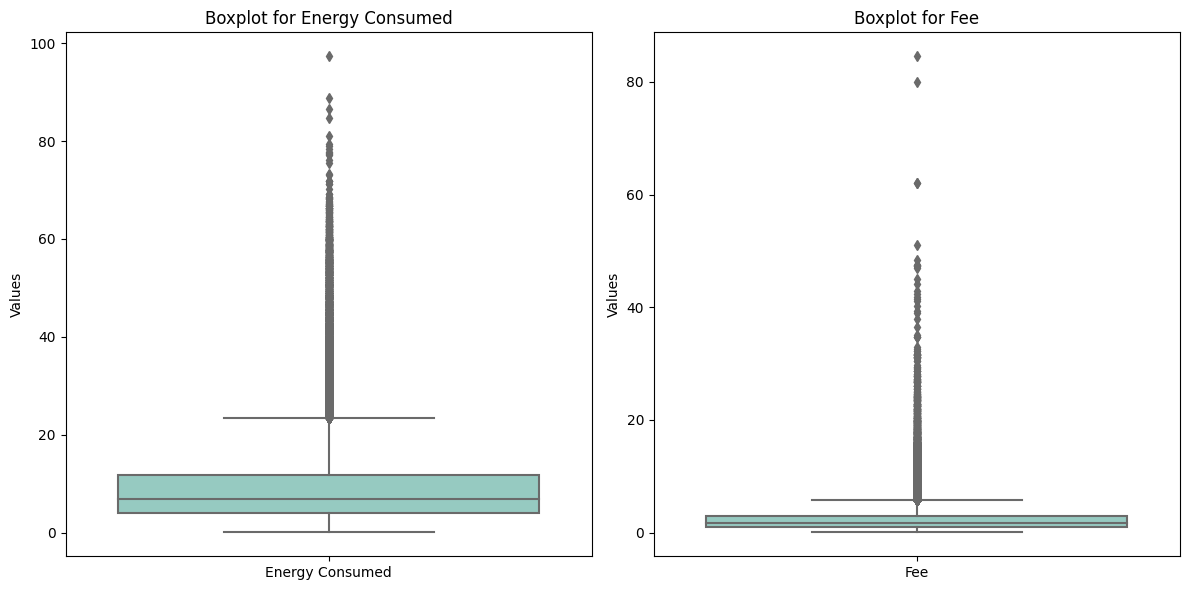

In [23]:
data_to_plot = df_processed[['Energy (kWh)', 'Fee']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create a boxplot for 'Energy Consumed'
sns.boxplot(data=data_to_plot['Energy (kWh)'], ax=ax1, palette='Set3')
ax1.set_title('Boxplot for Energy Consumed')
ax1.set_ylabel('Values')
ax1.set_xticklabels(['Energy Consumed'])

# Create a boxplot for 'Fee'
sns.boxplot(data=data_to_plot['Fee'], ax=ax2, palette='Set3')
ax2.set_title('Boxplot for Fee')
ax2.set_ylabel('Values')
ax2.set_xticklabels(['Fee'])

plt.tight_layout()

plt.show()

From the above plot we can see that there are outliers and hence we need to remove the outliers from Fee as well as Energy Consumed.

In [24]:
Q1_fee = df_processed['Fee'].quantile(0.25)
Q3_fee = df_processed['Fee'].quantile(0.75)
IQR_fee = Q3_fee - Q1_fee

Q1_energy = df_processed['Energy (kWh)'].quantile(0.25)
Q3_energy = df_processed['Energy (kWh)'].quantile(0.75)
IQR_energy = Q3_energy - Q1_energy

# Define the lower and upper bounds to identify outliers
lower_bound_fee = Q1_fee - 1.5 * IQR_fee
upper_bound_fee = Q3_fee + 1.5 * IQR_fee

lower_bound_energy = Q1_energy - 1.5 * IQR_energy
upper_bound_energy = Q3_energy + 1.5 * IQR_energy

# Remove outliers from 'Fee' and 'Energy (kWh)'
df_processed = df_processed[(df_processed['Fee'] >= lower_bound_fee) & (df_processed['Fee'] <= upper_bound_fee)]
df_processed = df_processed[(df_processed['Energy (kWh)'] >= lower_bound_energy) & (df_processed['Energy (kWh)'] <= upper_bound_energy)]

# Reset the index of the DataFrame
df_processed.reset_index(drop=True, inplace=True)
df_processed.shape

(119034, 2)

After removing the outliers we see that the correlation value increases.

In [25]:
correlation = df_processed['Fee'].corr(df_processed['Energy (kWh)'])

print("Correlation between Fee and Energy Consumed:", correlation)

Correlation between Fee and Energy Consumed: 0.9313474534861966


# Mode 1 : Linear Regression

+--------+---------------------+---------------------+
| Metric |        Train        |        Test         |
+--------+---------------------+---------------------+
|  RMSE  | 0.4509591412732515  | 0.4259692733670917  |
|  MSE   | 0.2033641470979084  | 0.18144982185288813 |
|  MAE   | 0.18190604442574249 | 0.17597385461972537 |
+--------+---------------------+---------------------+
Train accuracy : 0.8646967418777567
Test accuracy : 0.8783301764844439


<ipython-input-26-ed9b287d5fe4>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'RMSE', 'Train': rmse_train, 'Test': rmse_test}, ignore_index=True)
<ipython-input-26-ed9b287d5fe4>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'MSE', 'Train': mse_train, 'Test': mse_test}, ignore_index=True)
<ipython-input-26-ed9b287d5fe4>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'MAE', 'Train': mae_train, 'Test': mae_test}, ignore_index=True)


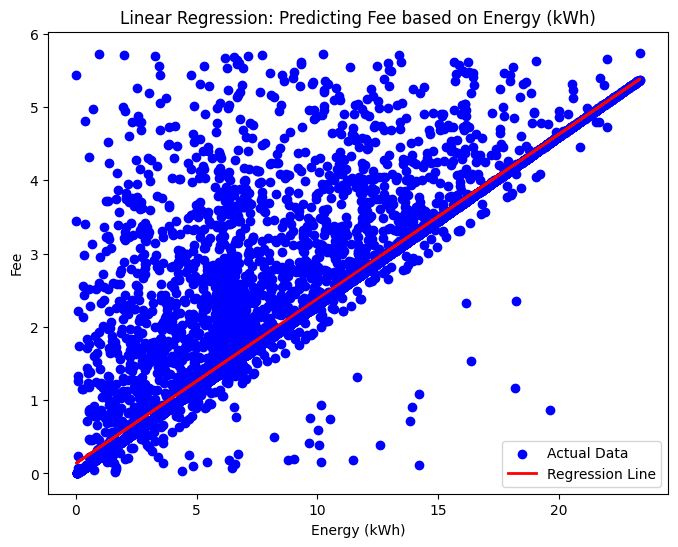

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt


X = df_processed[['Energy (kWh)']]  # Feature: Energy (kWh)
y = df_processed['Fee']  # Target: Fee

# Split the data into a training set and a testing set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_test_set = model.predict(X_test)
y_pred_train_set = model.predict(X_train)

# Calculate the model's performance metrics for test set
mse_test = mean_squared_error(y_test, y_pred_test_set)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test_set)

# Calculate the model's performance metrics for train set
mse_train = mean_squared_error(y_train, y_pred_train_set)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train_set)

# Print the model's performance metrics
results_df = pd.DataFrame(columns=['Metric', 'Train', 'Test'])
results_df = results_df.append({'Metric': 'RMSE', 'Train': rmse_train, 'Test': rmse_test}, ignore_index=True)
results_df = results_df.append({'Metric': 'MSE', 'Train': mse_train, 'Test': mse_test}, ignore_index=True)
results_df = results_df.append({'Metric': 'MAE', 'Train': mae_train, 'Test': mae_test}, ignore_index=True)

# Convert the DataFrame to a beautiful table
table = tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False)

# Display the beautiful table
print(table)
print("Train accuracy :",model.score(X_train,y_train))
print("Test accuracy :",model.score(X_test,y_test))

# Plot the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, y_pred_test_set, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Energy (kWh)')
plt.ylabel('Fee')
plt.title('Linear Regression: Predicting Fee based on Energy (kWh)')
plt.legend()
plt.show()


# Model 2 : XGBRegressor


<ipython-input-27-9b565bd6ed0f>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'RMSE', 'Train': rmse_train, 'Test': rmse_test}, ignore_index=True)
<ipython-input-27-9b565bd6ed0f>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'MSE', 'Train': mse_train, 'Test': mse_test}, ignore_index=True)
<ipython-input-27-9b565bd6ed0f>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'MAE', 'Train': mae_train, 'Test': mae_test}, ignore_index=True)


+--------+---------------------+---------------------+
| Metric |        Train        |        Test         |
+--------+---------------------+---------------------+
|  RMSE  | 0.44018028911231655 | 0.42775585280689343 |
|  MSE   | 0.1937586869230026  | 0.18297506961055268 |
|  MAE   | 0.17702105065030285 | 0.1753648508960715  |
+--------+---------------------+---------------------+
Training accuracy: 0.8710874949970984
Testing accuracy: 0.8773074329865582


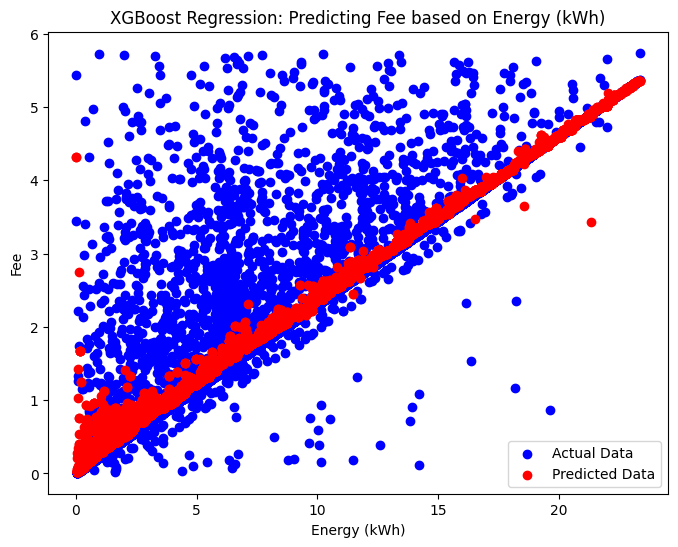

In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


X = df_processed[['Energy (kWh)']]  # Feature: Energy (kWh)
y = df_processed['Fee']  # Target: Fee

# Split the data into a training set and a testing set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)


# Make predictions on the testing data
y_pred_test_set = model.predict(X_test)
y_pred_train_set = model.predict(X_train)

# Calculate the model's performance metrics for test set
mse_test = mean_squared_error(y_test, y_pred_test_set)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test_set)

# Calculate the model's performance metrics for train set
mse_train = mean_squared_error(y_train, y_pred_train_set)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train_set)

# Print the model's performance metrics
results_df = pd.DataFrame(columns=['Metric', 'Train', 'Test'])
results_df = results_df.append({'Metric': 'RMSE', 'Train': rmse_train, 'Test': rmse_test}, ignore_index=True)
results_df = results_df.append({'Metric': 'MSE', 'Train': mse_train, 'Test': mse_test}, ignore_index=True)
results_df = results_df.append({'Metric': 'MAE', 'Train': mae_train, 'Test': mae_test}, ignore_index=True)

# Convert the DataFrame to a beautiful table
table = tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False)
print(table)

print("Training accuracy:",model.score(X_train,y_train))
print("Testing accuracy:",model.score(X_test,y_test))

# Plot the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_test_set, color='red', label='Predicted Data')
plt.xlabel('Energy (kWh)')
plt.ylabel('Fee')
plt.title('XGBoost Regression: Predicting Fee based on Energy (kWh)')
plt.legend()
plt.show()

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 100}


<ipython-input-28-e758e4bb61c1>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'RMSE', 'Train': rmse_train, 'Test': rmse_test}, ignore_index=True)
<ipython-input-28-e758e4bb61c1>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'MSE', 'Train': mse_train, 'Test': mse_test}, ignore_index=True)
<ipython-input-28-e758e4bb61c1>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Metric': 'MAE', 'Train': mae_train, 'Test': mae_test}, ignore_index=True)


+--------+---------------------+---------------------+
| Metric |        Train        |        Test         |
+--------+---------------------+---------------------+
|  RMSE  | 0.44701548112072753 | 0.42530278659344606 |
|  MSE   | 0.1998228403615955  | 0.1808824602841503  |
|  MAE   | 0.18021190036333629 | 0.17586391221951442 |
+--------+---------------------+---------------------+
Training accuracy: 0.8670528619031941
Testing accuracy: 0.8787106165489914


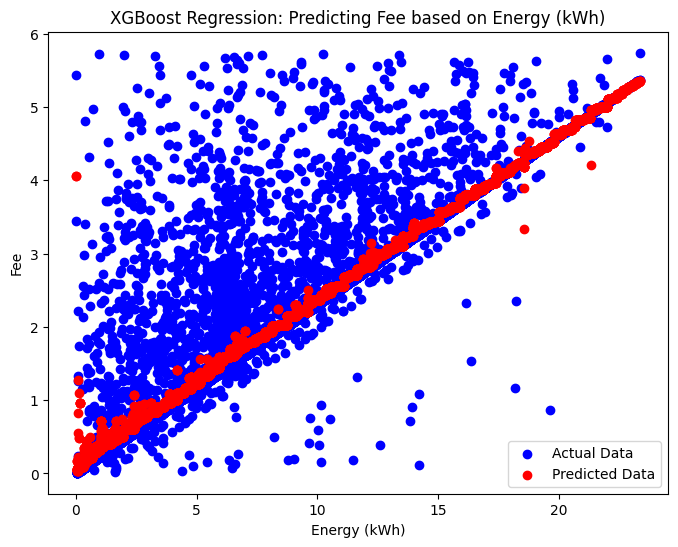

In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

X = df_processed[['Energy (kWh)']]  # Feature: Energy (kWh)
y = df_processed['Fee']  # Target: Fee

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define a grid of hyperparameters to search (only 'n_estimators' and 'max_depth')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a model with the best hyperparameters
best_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_test_set = best_model.predict(X_test)
y_pred_train_set = best_model.predict(X_train)

# Calculate the model's performance metrics for test set
mse_test = mean_squared_error(y_test, y_pred_test_set)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test_set)

# Calculate the model's performance metrics for train set
mse_train = mean_squared_error(y_train, y_pred_train_set)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train_set)

# Print the model's performance metrics
results_df = pd.DataFrame(columns=['Metric', 'Train', 'Test'])
results_df = results_df.append({'Metric': 'RMSE', 'Train': rmse_train, 'Test': rmse_test}, ignore_index=True)
results_df = results_df.append({'Metric': 'MSE', 'Train': mse_train, 'Test': mse_test}, ignore_index=True)
results_df = results_df.append({'Metric': 'MAE', 'Train': mae_train, 'Test': mae_test}, ignore_index=True)

# Convert the DataFrame to a beautiful table
table = tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False)
print(table)

print("Training accuracy:",best_model.score(X_train,y_train))
print("Testing accuracy:",best_model.score(X_test,y_test))

# Plot the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_test_set, color='red', label='Predicted Data')
plt.xlabel('Energy (kWh)')
plt.ylabel('Fee')
plt.title('XGBoost Regression: Predicting Fee based on Energy (kWh)')
plt.legend()
plt.show()